In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Steganography/Video and Audio files

/content/drive/.shortcut-targets-by-id/1oaZCwXh2SHDAQ3FtWzvS1pKkn3EYFRo1/Colab Notebooks/Steganography/Video and Audio files


<h1>Imports:</h1>

In [3]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from PIL import Image
import numpy as np 
from pydub import AudioSegment
import pywt
import soundfile as sf


<h1>THE PROCESS</h1>

In [102]:
def Audio_Encode(img, audio_8b):
  count = 0
  shape = img.shape
  aud = audio_8b.copy()
  img = img.ravel()
  for i in range(len(img)):
      try: data = aud[0]
      except:   
        break;
      bits = data & 192
      bits = bits >> 6
      
      img[i] = ((img[i] & 0b11111100) | bits)
    
      count += 1
      data = data << 2
      
      aud[0] = data
      if count == 4:
        del aud[0]
        count = 0
  return img.reshape(shape), aud


      


In [103]:
import random
test_img = np.empty((0,8),int)
for i in range(6):
  lst = []
  for j in range(8):
    pix = random.randint(0,255)
    
    lst.append(pix)
 
  test_img = np.append(test_img, [lst] , axis=0)

print(test_img)


[[ 71 255   5   5 174  17 248   4]
 [156 109   9 235 231 161  76 243]
 [ 36 206 161 142 108 195 232  58]
 [ 77 239  55 184 110 124  45  80]
 [ 17 247  28  80 192 110 149 218]
 [112 104  33  29   5 249 208 123]]


In [104]:
audio = []
for i in range(0,6):
  n = random.randint(0,255)
  audio.append(n)
print(audio)

[181, 72, 169, 14, 75, 73]


In [105]:

def Audio_Decode(encoded_img, nop):
  
  img = encoded_img.ravel()

  if nop < img.size:
    loop = nop
  else: 
    loop = img.size

  count=0  
  audio_obt = []
  data = 0
  for i in range(loop):
    pix = img[i]
    bits = pix & 3
    data =  data << 2 | bits
    count += 1
    if count == 4:
      audio_obt.append(data)
      data = 0
      count = 0
    
    info = {
        'audio' : audio_obt,
        'rem_bits' : 4-count, 
        'lastdata': data 
    }


  return info 
  



<h1>Implementation</h1>

In [106]:
def to_mono(filename):
  sound = AudioSegment.from_wav(filename)
  sound = sound.set_channels(1)
  sound.export(filename, format="wav")

In [107]:
audio_file = 'secretaudio.wav'
to_mono(audio_file)
signal, sr = sf.read(audio_file,dtype='int16')


In [108]:
image_file = '../Nikesh.jpg'
cover_image = Image.open(image_file).convert('YCbCr')


In [109]:
Cb = cover_image.getchannel('Cb')
Cr = cover_image.getchannel('Cr')
Y = cover_image.getchannel('Y')

Cb = np.array(Cb)
Cr = np.array(Cr)




In [110]:
channel1=np.array(signal)
channel1= channel1+ 32768
channel1front=channel1/256
channel1end= channel1front- channel1front.astype(int)
channel1front=channel1front.astype(int)


channel1end= channel1end* 256
channel1end= channel1end.astype(int)

In [111]:
Cb_encoded, rem = Audio_Encode(Cb, list(channel1front)) 
Cr_encoded, rem = Audio_Encode(Cr, list(channel1end)) 

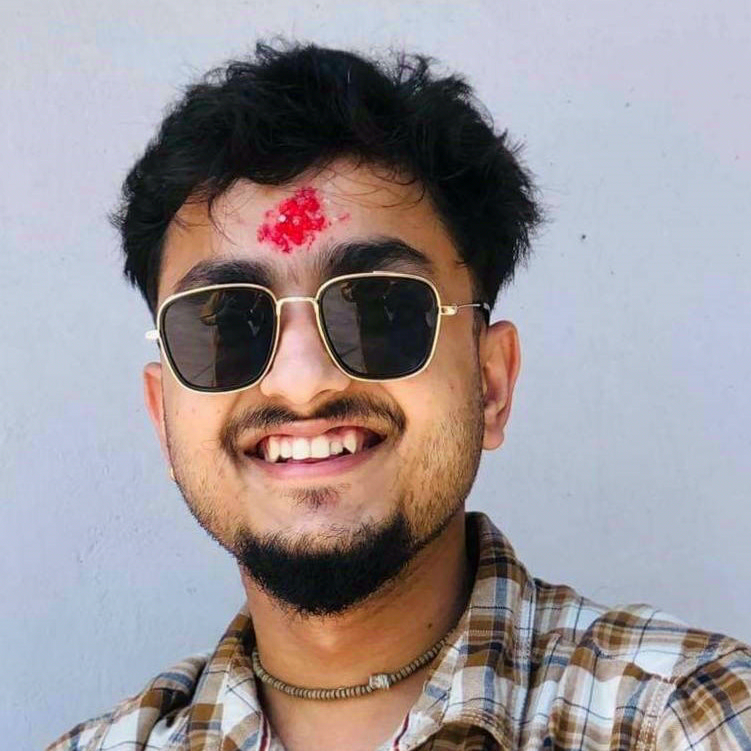

In [112]:
Cb_encoded = Image.fromarray(Cb_encoded)
Cr_encoded = Image.fromarray(Cr_encoded)

stego_img = Image.merge("YCbCr", (Y, Cb_encoded, Cr_encoded))

stego_img.show()

In [113]:
channelfront_obt = Audio_Decode(np.array(Cb_encoded), channel1front.size*4)['audio']
channelend_obt = Audio_Decode(np.array(Cr_encoded), channel1end.size*4)['audio']

In [114]:
channelfront_obt = np.array(channelfront_obt)
channelend_obt = np.array(channelend_obt)
audio_obt=channelfront_obt +(channelend_obt/256)
audio_obt=(audio_obt*256).astype(int)
audio_obt= (audio_obt-32768).astype('int16')

output_file = 'obtained.wav'
sf.write(output_file, audio_obt, sr)